# Homework #3 -- *you'll need to do this on google colab*

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***. 
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified. 
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on... 

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains. 

Data is from https://www.kaggle.com/datasets/mrsimple07/obesity-prediction?resource=download

In [15]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import scipy.stats as stats

In [2]:
dataset = pd.read_csv('obesity_data.csv')

In [55]:
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model: 
    theta = pm.Normal("theta", mu=20, sigma=20)
    phi = pm.Gamma("phi", alpha=20, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=dataset["Weight"])
    idata_HMC = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [56]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')

HMC Split-Rhats {'theta': 1.0007, 'phi': 1.0007} | 

/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestp

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

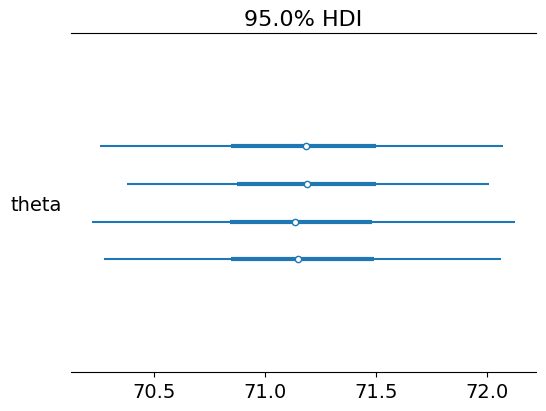

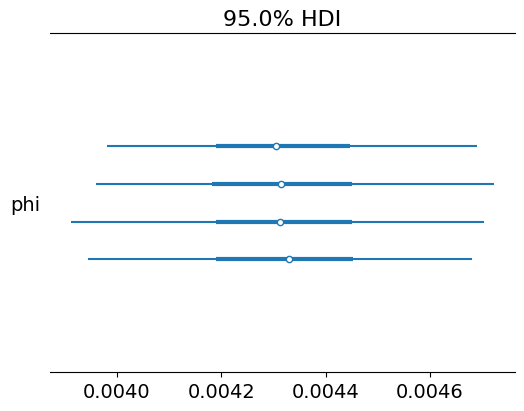

In [58]:
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95)
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

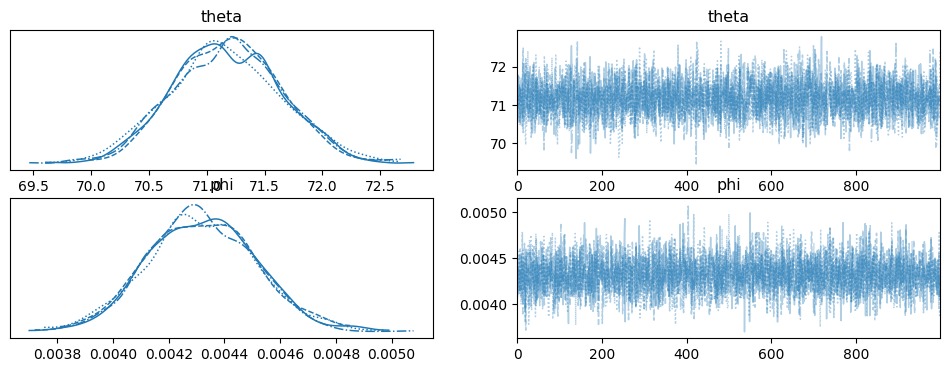

In [59]:
az.plot_trace(idata_HMC)

(array([0.00150794, 0.0042007 , 0.00893995, 0.01658739, 0.02455795,
        0.02628131, 0.01507944, 0.00797056, 0.00193879, 0.00064626]),
 array([ 26.06572953,  35.3498932 ,  44.63405687,  53.91822053,
         63.2023842 ,  72.48654787,  81.77071154,  91.05487521,
        100.33903887, 109.62320254, 118.90736621]),
 <BarContainer object of 10 artists>)

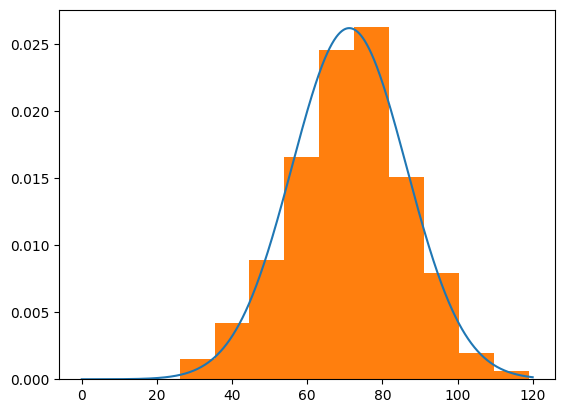

In [61]:
plt.plot(np.linspace(0,120,1000), stats.norm(loc=idata_HMC.posterior['theta'].mean(),scale=1/idata_HMC.posterior['phi'].mean()**0.5).pdf(np.linspace(0,120,1000)))
plt.hist(dataset["Weight"], density=True)

Both the Split-Rhats, the traces and the average generated distribution look good

The distribution of Physical Activity Level is far from a normal distribution. Further, it is a discrete distribution with four options, which can only really be fit with a generic categorical distribution.

(array([0.79666667, 0.        , 0.        , 0.82333333, 0.        ,
        0.        , 0.85      , 0.        , 0.        , 0.86333333]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

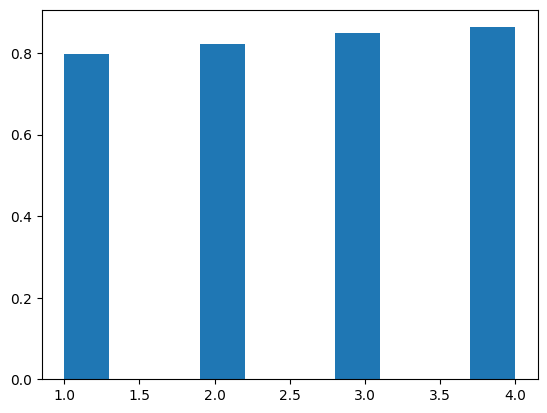

In [62]:
plt.hist(dataset["PhysicalActivityLevel"], density=True)

In [81]:
pd.get_dummies(dataset["PhysicalActivityLevel"]).to_numpy().astype(float)

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [88]:
physical_model = pm.Model()
with physical_model: 
    prior = pm.Gamma("prior", alpha=1, beta=1, shape=5)
    x_obs = pm.Categorical(name="physical", p=prior / prior.sum(), observed=dataset["PhysicalActivityLevel"])
    phy_data = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [90]:
phy_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

HMC Split-Rhats {'prior': array([1.0011, 1.0067, 1.0065, 1.0053, 1.0059])} | 

/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/dev/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([[<Axes: title={'center': 'prior'}>,
        <Axes: title={'center': 'prior'}>]], dtype=object)

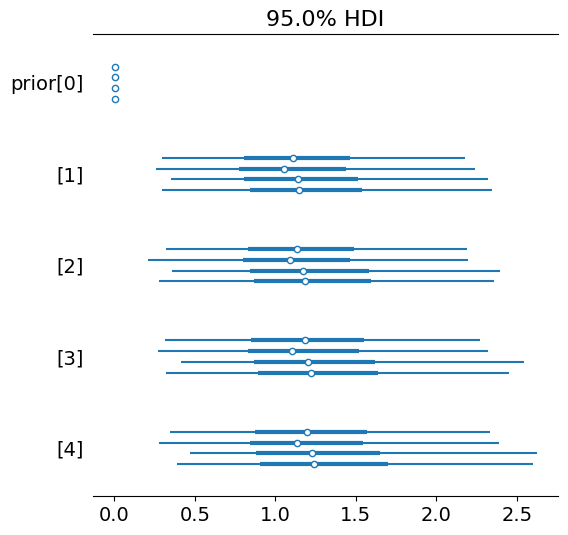

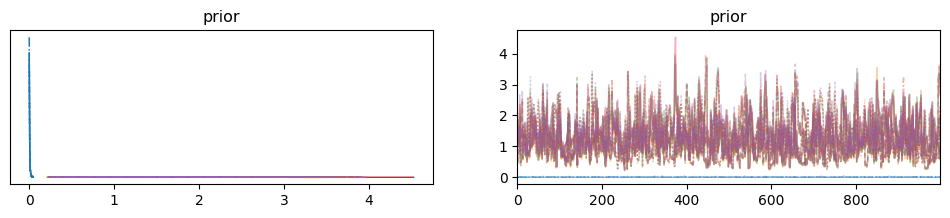

In [91]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(phy_data).items()}, end=' | ')
az.plot_forest(phy_data, var_names=["prior"], combined=False, hdi_prob=0.95)
az.plot_trace(phy_data)

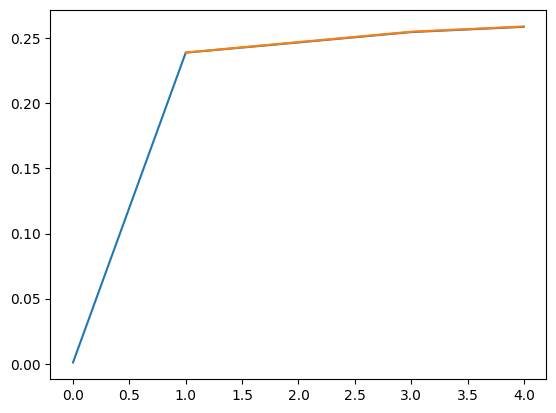

In [112]:
v = phy_data.posterior["prior"].mean(axis=0).mean(axis=0)
plt.plot(v / v.sum())
plt.plot(dataset["PhysicalActivityLevel"].value_counts() / dataset["PhysicalActivityLevel"].count())

The two distributions are identical, further the Split-Rhats, HDI plots all show that the chain has converged.